In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.dates as mdates

In [13]:
import pandas as pd

def load_and_preprocess_data(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Convert 'Date' and 'Arrival Time' to appropriate datetime formats
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], format='%H:%M:%S').dt.time

    # Extract hour and minute from 'Arrival Time'
    df['arrival_hour'] = df['Arrival Time'].apply(lambda x: x.hour)
    df['arrival_minute'] = df['Arrival Time'].apply(lambda x: x.minute)

    # Compute minutes after noon (12:00 PM)
    df['arrival_minutes_after_noon'] = (
        df['arrival_hour'] * 60 + df['arrival_minute'] - (12 * 60)
    )

    # Map weekdays to numerical values
    weekday_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
        'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }
    df['day_of_week'] = df['Week Day'].map(weekday_map)

    # Normalize numerical weather-related columns
    weather_features = [
        'temperature_2m', 'apparent_temperature', 'precipitation',
        'wind_speed_10m', 'relative_humidity_2m', 'cloud_cover'
    ]
    for feature in weather_features:
        df[f'{feature}_normalized'] = (df[feature] - df[feature].mean()) / df[feature].std()

    # Add a feature indicating whether it is morning (before noon) or afternoon
    df['is_morning'] = df['arrival_hour'] < 12

    return df



In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def visualize_data(df):
    # Ensure arrival_minutes_after_noon is correctly calculated
    df['arrival_minutes_after_noon'] = df['arrival_hour'] * 60 + df['arrival_minute'] - (12 * 60)

    # Plot: Bus Arrival Time Distribution (Afternoon)
    plt.figure(figsize=(12, 6))
    plt.scatter(df['Date'], df['arrival_minutes_after_noon'],
                label='Arrival Time (minutes after noon)', alpha=0.6, c='blue')
    plt.xlabel('Date')
    plt.ylabel('Arrival Time (minutes after noon)')
    plt.title('Bus Arrival Time Distribution (Afternoon)')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Boxplot: Impact of Weather on Afternoon Arrival Time
    weather_columns = [col for col in df.columns if 'Weather_' in col]
    for weather_col in weather_columns:
        df.boxplot(column='arrival_minutes_after_noon', by=weather_col)
        plt.title(f'Impact of {weather_col} on Afternoon Arrival Time')
        plt.xlabel('Weather Condition')
        plt.ylabel('Arrival Time (minutes after noon)')
        plt.suptitle('')  # Suppress default suptitle
        plt.show()

    # Boxplot: Impact of Morning vs Afternoon on Arrival Time
    df.boxplot(column='arrival_minutes_after_noon', by='is_morning')
    plt.title('Impact of Morning vs Afternoon on Arrival Time')
    plt.xlabel('Is Morning')
    plt.ylabel('Arrival Time (minutes after noon)')
    plt.suptitle('')  # Suppress default suptitle
    plt.show()

    # Additional Analysis: Boxplots for Normalized Weather Features
    weather_features = [
        'temperature_2m_normalized', 'apparent_temperature_normalized',
        'precipitation_normalized', 'wind_speed_10m_normalized',
        'relative_humidity_2m_normalized', 'cloud_cover_normalized'
    ]
    for feature in weather_features:
        df.boxplot(column='arrival_minutes_after_noon', by=feature)
        plt.title(f'Impact of {feature} on Afternoon Arrival Time')
        plt.xlabel(feature)
        plt.ylabel('Arrival Time (minutes after noon)')
        plt.suptitle('')  # Suppress default suptitle
        plt.show()




In [15]:
def train_and_optimize_model(df):
    # Define feature columns and target column
    feature_cols = ['day_of_week', 'arrival_hour', 'arrival_minute'] + [col for col in df.columns if 'Weather_' in col]
    X = df[feature_cols]
    y = df['arrival_minutes_after_noon']

    # Check for missing values and handle them
    if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
        raise ValueError("Feature or target data contains missing values. Please clean the data before training.")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the parameter grid for optimization
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize the grid search with cross-validation
    print("Starting Grid Search...")
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_absolute_error',
        verbose=1,
        n_jobs=-1
    )

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")

    # Evaluate the model on the test data
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Optimized Mean Absolute Error (MAE): {mae:.2f} minutes")

    # Optionally, return additional information like the full grid search results
    return best_model, grid_search.cv_results_



In [16]:
def predict_afternoon_arrivals(model, day_of_week, weather_condition, feature_columns, start_hour=12, end_hour=18, interval=15):
    from datetime import timedelta

    # Generate minute intervals for prediction
    arrival_minutes = list(range((start_hour - 12) * 60, (end_hour - 12) * 60, interval))
    predictions = []

    # Iterate over time intervals to generate predictions
    for minute_after_noon in arrival_minutes:
        hour = (minute_after_noon // 60) + 12
        minute = minute_after_noon % 60

        # Prepare input data dynamically based on the provided feature columns
        input_data = {
            'day_of_week': [day_of_week],
            'arrival_hour': [hour],
            'arrival_minute': [minute],
        }

        # Add weather-related features
        for col in feature_columns:
            if col.startswith('Weather_'):
                input_data[col] = [0]
            elif col.endswith('_normalized'):
                input_data[col] = [0]  # Default normalization value if not specified

        # Set the specified weather condition to 1
        if weather_condition in input_data:
            input_data[weather_condition] = [1]

        # Create a DataFrame for prediction
        input_df = pd.DataFrame(input_data)

        # Predict and convert minutes after noon back to time
        predicted_minutes_after_noon = model.predict(input_df)[0]
        predicted_hour = int(predicted_minutes_after_noon // 60) + 12
        predicted_minute = int(predicted_minutes_after_noon % 60)
        predicted_time = f"{predicted_hour:02d}:{predicted_minute:02d}"
        predictions.append(predicted_time)

    # Consolidate predictions based on the interval
    consolidated_predictions = []
    for time in predictions:
        if not consolidated_predictions or abs(
            int(time.split(":")[0]) * 60 + int(time.split(":")[1]) -
            int(consolidated_predictions[-1].split(":")[0]) * 60 -
            int(consolidated_predictions[-1].split(":")[1])
        ) >= interval:
            consolidated_predictions.append(time)

    return consolidated_predictions


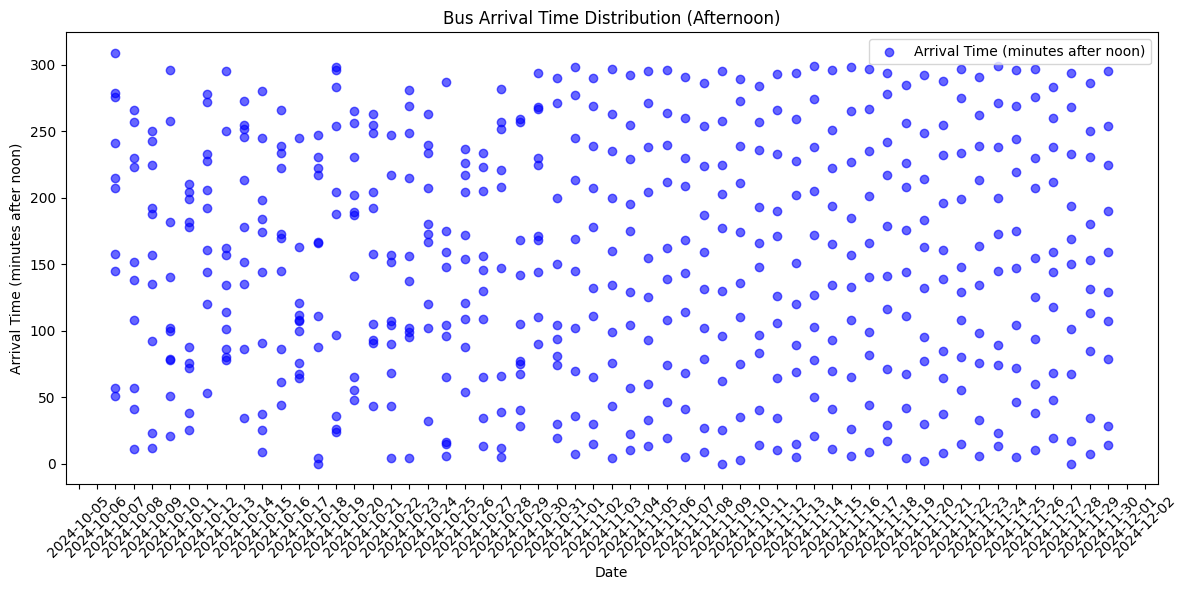

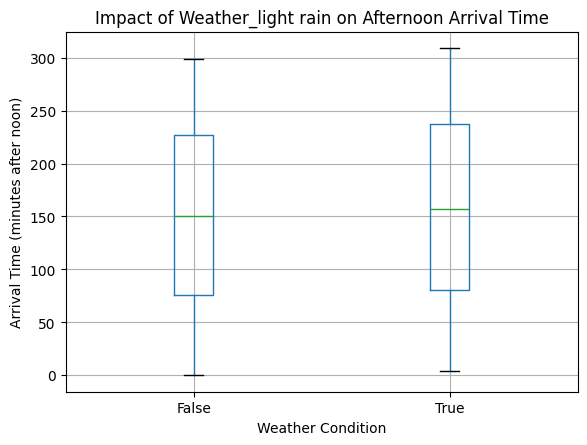

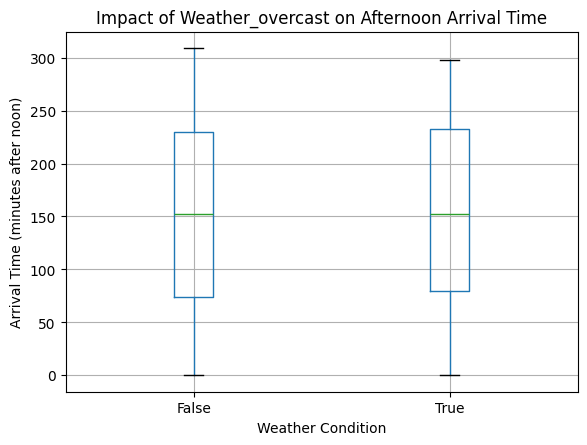

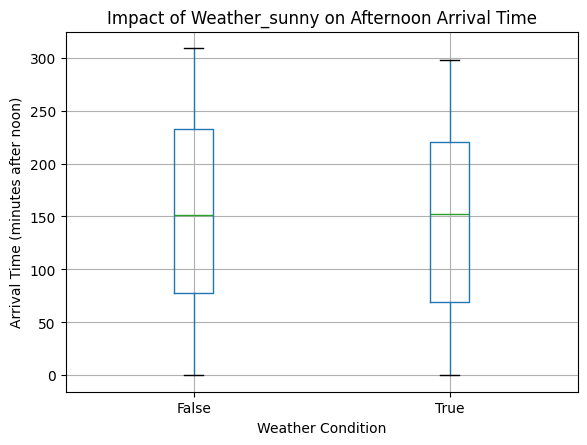

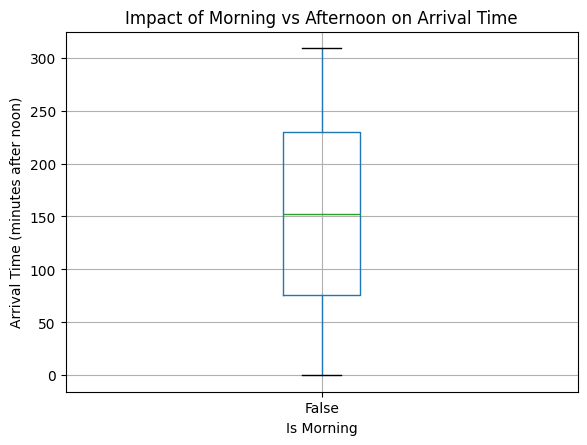

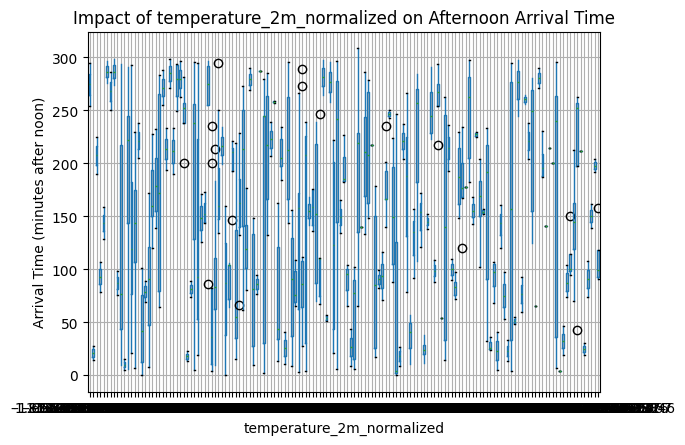

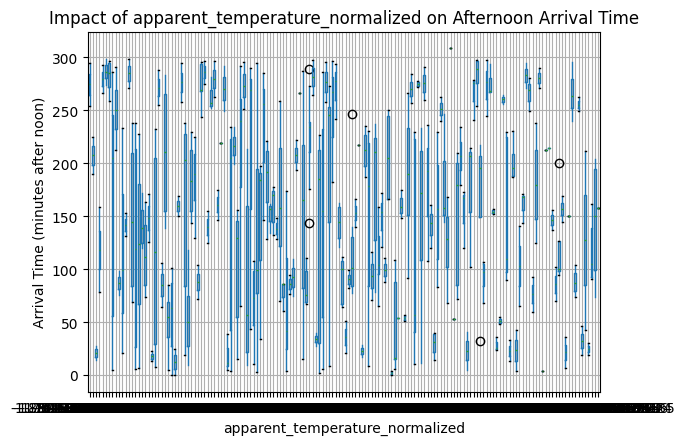

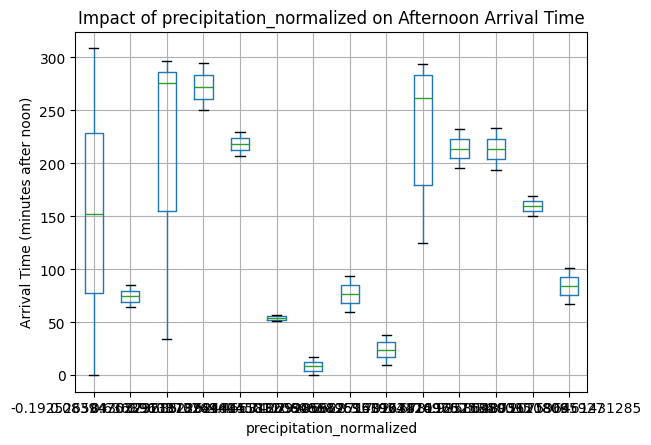

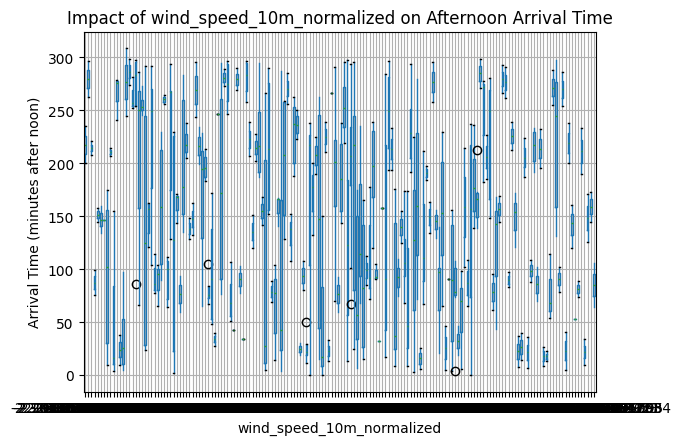

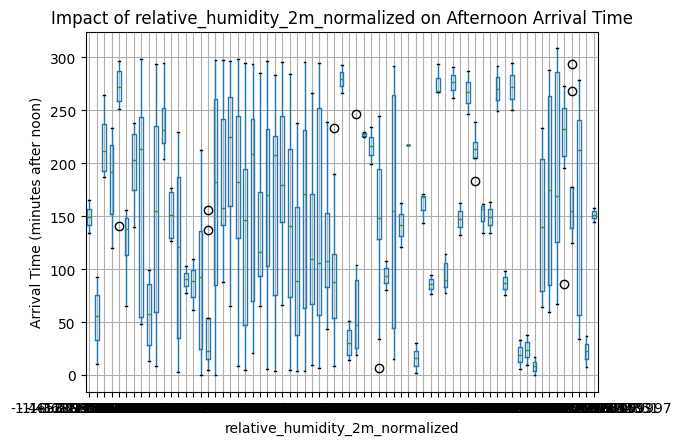

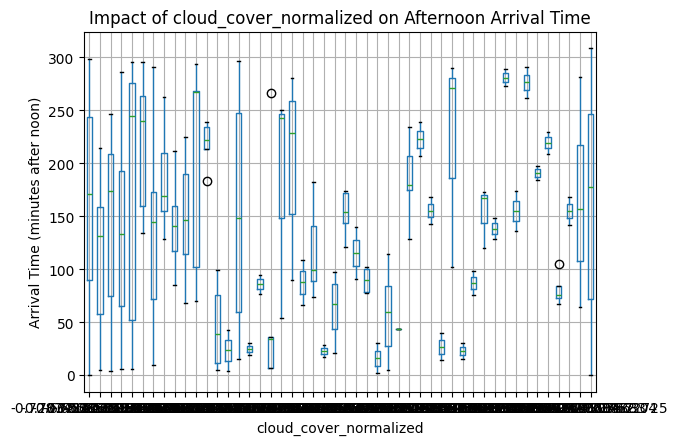

Starting Grid Search...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Optimized Mean Absolute Error (MAE): 0.98 minutes
Predicted Afternoon Arrival Times:
12:00
12:15
12:44
13:00
13:29
13:44
14:01
14:30
15:01
15:29
15:45
16:01
16:29
16:44
16:01
16:29
16:44


In [17]:
if __name__ == "__main__":
    file_path = "bus_arrival_schedule_with_weather.csv"
    df = load_and_preprocess_data(file_path)
    visualize_data(df)
    best_model, cv_results = train_and_optimize_model(df)
    feature_columns = ['day_of_week', 'arrival_hour', 'arrival_minute'] + [col for col in df.columns if 'Weather_' in col]

    # 调用 predict_afternoon_arrivals 并传入所有参数
    predicted_times = predict_afternoon_arrivals(
        model=best_model,
        day_of_week=0,  # 假设预测的是星期一
        weather_condition='Weather_light rain',  # 天气条件
        feature_columns=feature_columns,  # 特征列
        start_hour=12,  # 下午 12 点开始
        end_hour=18,  # 下午 6 点结束
        interval=15  # 每 15 分钟间隔
    )
    print("Predicted Afternoon Arrival Times:")
    for time in predicted_times:
        print(time)

